In [1]:
import os
import tensorflow as tf
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# location of data
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# download the data and extract it
path_to_zip = utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

# construct paths
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# parameters for datasets
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# construct train and validation datasets 
train_dataset = utils.image_dataset_from_directory(train_dir,
                                                   shuffle=True,
                                                   batch_size=BATCH_SIZE,
                                                   image_size=IMG_SIZE)

validation_dataset = utils.image_dataset_from_directory(validation_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)

# construct the test dataset by taking every 5th observation out of the validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


2022-05-29 13:23:30.038695: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


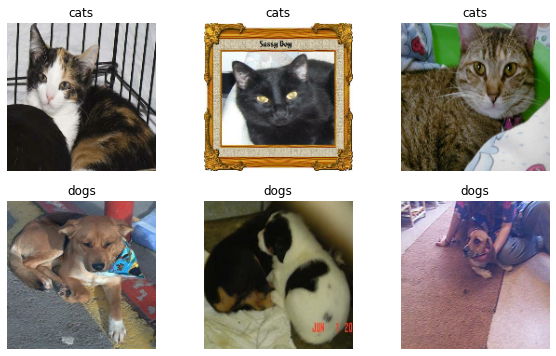

In [3]:
def plot_images(dataset):
    class_names = dataset.class_names
    plt.figure(figsize= (10, 6))
    for images, labels in dataset.take(1):
        x = 0
        for i in range(len(images)):
            if(x < 3):
                if(class_names[labels[i]] == "cats"):
                    ax = plt.subplot(2, 3, x + 1)
                    plt.imshow(images[i].numpy().astype("uint8"))
                    plt.title(class_names[labels[i]])
                    plt.axis("off")
                    x += 1
            if(x >= 3):
                if(class_names[labels[i]] == "dogs"):
                    ax = plt.subplot(2, 3, x + 1)
                    plt.imshow(images[i].numpy().astype("uint8"))
                    plt.title(class_names[labels[i]])
                    plt.axis("off")
                    x += 1
            if(x >= 6):
                break
plot_images(train_dataset)

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
labels_iterator= train_dataset.unbatch().map(tf.autograph.experimental.do_not_convert(lambda image, label: label)).as_numpy_iterator()
catcount, dogcount = 0, 0
for x in labels_iterator:
    if x == 0:
        catcount += 1
    else:
        dogcount += 1
print(catcount)
print(dogcount)
#The baseline model would be accurate 50% of the time

1000
1000


In [6]:
tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

num_classes = 2
model1 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

model1.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history1 = model1.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 34s 522ms/step - loss: 0.7239 - accuracy: 0.5210 - val_loss: 0.6792 - val_accuracy: 0.6027
Epoch 2/20
63/63 [==============================] - 33s 517ms/step - loss: 0.6640 - accuracy: 0.6115 - val_loss: 0.6716 - val_accuracy: 0.6225
Epoch 3/20
63/63 [==============================] - 32s 499ms/step - loss: 0.6197 - accuracy: 0.6545 - val_loss: 0.6372 - val_accuracy: 0.6671
Epoch 4/20
63/63 [==============================] - 35s 549ms/step - loss: 0.5611 - accuracy: 0.7145 - val_loss: 0.6400 - val_accuracy: 0.6547
Epoch 5/20
63/63 [==============================] - 35s 561ms/step - loss: 0.4936 - accuracy: 0.7635 - val_loss: 0.6452 - val_accuracy: 0.6510
Epoch 6/20
63/63 [==============================] - 32s 500ms/step - loss: 0.4242 - accuracy: 0.8035 - val_loss: 0.6914 - val_accuracy: 0.6275
Epoch 7/20
63/63 [==============================] - 32s 511ms/step - loss: 0.3456 - accuracy: 0.8465 - val_loss: 0.6891 - val_accuracy: 0.6535

In [7]:
#My model stabilized between 68-73% accuracy. This is better than the
#baseline of 50% accuracy. However, considering the difference between
#training accuracy(~95%) and validation accuracy(~71%), it is clear
#that overfitting occured with this model.

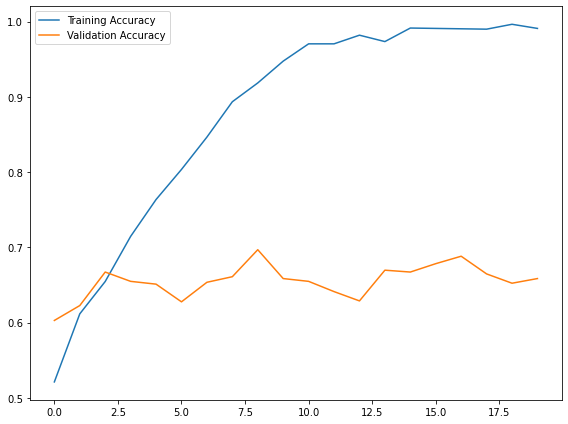

In [11]:
def plot_model(history):
    model_history = pd.DataFrame(history.history)
    model_history['epoch'] = history.epoch
    fig, ax = plt.subplots(1, figsize=(8,6))
    num_epochs = model_history.shape[0]
    ax.plot(np.arange(0, num_epochs), model_history["accuracy"], 
        label="Training Accuracy")
    ax.plot(np.arange(0, num_epochs), model_history["val_accuracy"], 
        label="Validation Accuracy")
    ax.legend()
    plt.tight_layout()
    plt.show()
plot_model(history1)

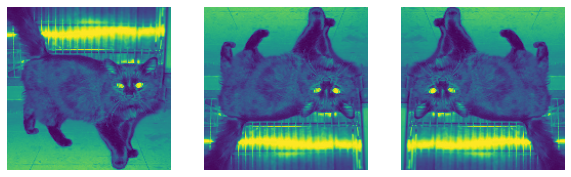

In [12]:
image,labels = next(iter(train_dataset))
random_flip = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=.5)
])
plt.figure(figsize=(10, 3))
ax = plt.subplot(1, 3, 1)
plt.imshow(image[0,:,:,0])
plt.axis("off")
for i in range(2):
    augmented_image = random_flip(image)
    ax = plt.subplot(1, 3, i + 2)
    plt.imshow(augmented_image[0,:,:,0])
    plt.axis("off")

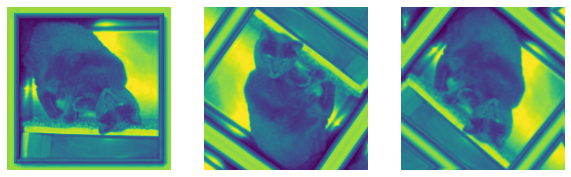

In [10]:
image, label = next(iter(train_dataset))
random_rotation = tf.keras.Sequential([
   tf.keras.layers.RandomRotation(0.7, seed=1)
])
plt.figure(figsize=(10, 3))
ax = plt.subplot(1, 3, 1)
plt.imshow(image[0,:,:,0])
plt.axis("off")
for i in range(2):
    augmented_image = random_rotation(image)
    ax = plt.subplot(1, 3, i + 2)
    plt.imshow(augmented_image[0,:,:,0])
    plt.axis("off")
    image = augmented_image

In [13]:
model2 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])
model2.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history2 = model2.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 38s 588ms/step - loss: 0.7398 - accuracy: 0.5180 - val_loss: 0.6914 - val_accuracy: 0.5297
Epoch 2/20
63/63 [==============================] - 36s 566ms/step - loss: 0.6922 - accuracy: 0.5365 - val_loss: 0.6874 - val_accuracy: 0.5755
Epoch 3/20
63/63 [==============================] - 35s 560ms/step - loss: 0.6891 - accuracy: 0.5400 - val_loss: 0.6922 - val_accuracy: 0.5074
Epoch 4/20
63/63 [==============================] - 34s 545ms/step - loss: 0.6918 - accuracy: 0.5140 - val_loss: 0.6863 - val_accuracy: 0.5198
Epoch 5/20
63/63 [==============================] - 34s 539ms/step - loss: 0.6905 - accuracy: 0.5195 - val_loss: 0.6888 - val_accuracy: 0.5483
Epoch 6/20
63/63 [==============================] - 34s 538ms/step - loss: 0.6918 - accuracy: 0.5405 - val_loss: 0.6890 - val_accuracy: 0.5210
Epoch 7/20
63/63 [==============================] - 41s 649ms/step - loss: 0.6846 - accuracy: 0.5395 - val_loss: 0.6869 - val_accuracy: 0.5520

In [ ]:
#My model stabilized between 68-73% accuracy. This is
#pretty similar to model1. However, considering the difference between
#training accuracy(~72%) and validation accuracy(~71%), it is clear
#that there was less overfitting with this model.

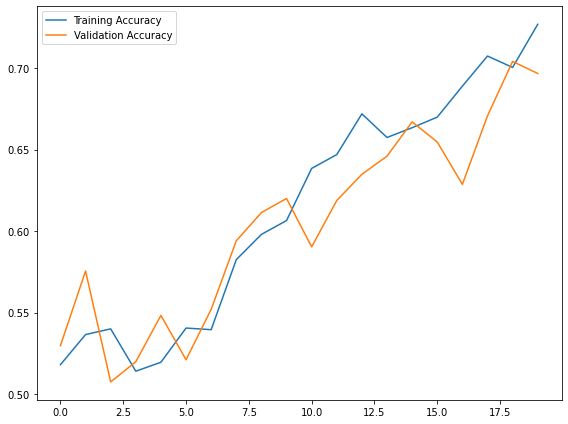

In [14]:
plot_model(history2)

In [15]:
i = tf.keras.Input(shape=(160, 160, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(i)
preprocessor = tf.keras.Model(inputs = [i], outputs = [x])

model3 = tf.keras.Sequential([
    preprocessor,
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])
model3.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history3 = model3.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 34s 516ms/step - loss: 0.7111 - accuracy: 0.5330 - val_loss: 0.6820 - val_accuracy: 0.5606
Epoch 2/20
63/63 [==============================] - 33s 526ms/step - loss: 0.6574 - accuracy: 0.6040 - val_loss: 0.6599 - val_accuracy: 0.5347
Epoch 3/20
63/63 [==============================] - 33s 524ms/step - loss: 0.6324 - accuracy: 0.6395 - val_loss: 0.6204 - val_accuracy: 0.6225
Epoch 4/20
63/63 [==============================] - 33s 522ms/step - loss: 0.6240 - accuracy: 0.6470 - val_loss: 0.6166 - val_accuracy: 0.6757
Epoch 5/20
63/63 [==============================] - 33s 517ms/step - loss: 0.5966 - accuracy: 0.6700 - val_loss: 0.6020 - val_accuracy: 0.6856
Epoch 6/20
63/63 [==============================] - 33s 518ms/step - loss: 0.5857 - accuracy: 0.6795 - val_loss: 0.6056 - val_accuracy: 0.6683
Epoch 7/20
63/63 [==============================] - 33s 516ms/step - loss: 0.5816 - accuracy: 0.6920 - val_loss: 0.5681 - val_accuracy: 0.7017

In [ ]:
#My model stabilized between 72-74% accuracy. This is better than the
#slightly better than model1. Considering the difference between
#training accuracy(~75%) and validation accuracy(~73%), it is clear
#that there was not much overfitting with this model.

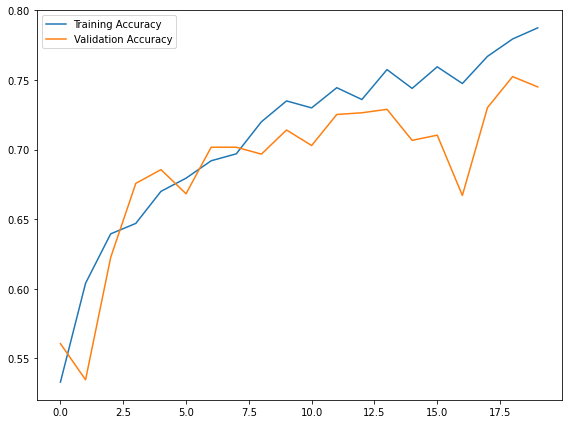

In [16]:
plot_model(history3)

In [17]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

i = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(i, training = False)
base_model_layer = tf.keras.Model(inputs = [i], outputs = [x])

In [18]:
model4 = tf.keras.Sequential([
    preprocessor,
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    base_model_layer,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])
model4.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history4 = model4.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 38s 557ms/step - loss: 0.7410 - accuracy: 0.8960 - val_loss: 0.0707 - val_accuracy: 0.9777
Epoch 2/20
63/63 [==============================] - 34s 531ms/step - loss: 0.1442 - accuracy: 0.9400 - val_loss: 0.0525 - val_accuracy: 0.9777
Epoch 3/20
63/63 [==============================] - 34s 537ms/step - loss: 0.1246 - accuracy: 0.9510 - val_loss: 0.0549 - val_accuracy: 0.9814
Epoch 4/20
63/63 [==============================] - 33s 529ms/step - loss: 0.1328 - accuracy: 0.9415 - val_loss: 0.0552 - val_accuracy: 0.9790
Epoch 5/20
63/63 [==============================] - 33s 529ms/step - loss: 0.1010 - accuracy: 0.9645 - val_loss: 0.0600 - val_accuracy: 0.9802
Epoch 6/20
63/63 [==============================] - 34s 533ms/step - loss: 0.0855 - accuracy: 0.9640 - val_loss: 0.0546 - val_accuracy: 0.9777
Epoch 7/20
63/63 [==============================] - 33s 528ms/step - loss: 0.0803 - accuracy: 0.9690 - val_loss: 0.0505 - val_accuracy: 0.9814

In [ ]:
#My model stabilized between 98-99% accuracy. This is
#much better accuracy than model1. Considering the difference between
#training accuracy(~98%) and validation accuracy(~99%), it is clear
#that there was little overfitting with this model.

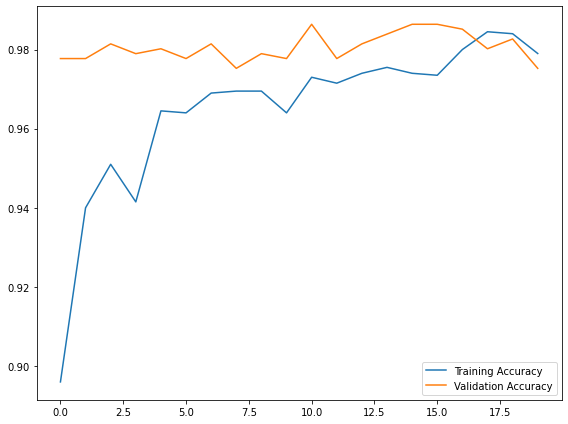

In [19]:
plot_model(history4)

In [20]:
model4.evaluate(test_dataset)

6/6 [==============================] - 3s 395ms/step - loss: 0.0776 - accuracy: 0.9583


[0.0775797963142395, 0.9583333134651184]